In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [5]:
# Dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [8]:
def imshow(img):
    img = img/ 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

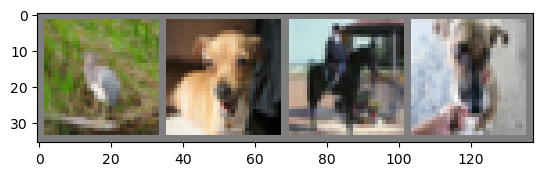

In [10]:
imshow(torchvision.utils.make_grid(images))

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        # -> n, 3, 32, 32 (first)
        x = self.pool(F.relu(self.conv1(x))) # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) # -> n, 16, 5, 5
        x = x.view( -1, 16*5*5)              # -> n, 400
        x = F.relu(self.fc1(x))              # -> n, 120
        x = F.relu(self.fc2(x))              # -> n, 84
        x = self.fc3(x)                      # -> n, 10
        return x

In [21]:
model = ConvNet().to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

In [23]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i,(images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3074
Epoch [1/5], Step [4000/12500], Loss: 2.2952
Epoch [1/5], Step [6000/12500], Loss: 2.3110
Epoch [1/5], Step [8000/12500], Loss: 2.3208
Epoch [1/5], Step [10000/12500], Loss: 2.2733
Epoch [1/5], Step [12000/12500], Loss: 2.2992
Epoch [2/5], Step [2000/12500], Loss: 2.3175
Epoch [2/5], Step [4000/12500], Loss: 1.8829
Epoch [2/5], Step [6000/12500], Loss: 1.8729
Epoch [2/5], Step [8000/12500], Loss: 1.7998
Epoch [2/5], Step [10000/12500], Loss: 1.7180
Epoch [2/5], Step [12000/12500], Loss: 1.3943
Epoch [3/5], Step [2000/12500], Loss: 1.2611
Epoch [3/5], Step [4000/12500], Loss: 1.4416
Epoch [3/5], Step [6000/12500], Loss: 1.5704
Epoch [3/5], Step [8000/12500], Loss: 1.1970
Epoch [3/5], Step [10000/12500], Loss: 1.2461
Epoch [3/5], Step [12000/12500], Loss: 2.3203
Epoch [4/5], Step [2000/12500], Loss: 1.1313
Epoch [4/5], Step [4000/12500], Loss: 2.3040
Epoch [4/5], Step [6000/12500], Loss: 0.5370
Epoch [4/5], Step [8000/12500], Loss: 1.8529
Epoc

In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.17 %
Accuracy of plane: 43.7 %
Accuracy of car: 66.3 %
Accuracy of bird: 29.9 %
Accuracy of cat: 16.2 %
Accuracy of deer: 27.9 %
Accuracy of dog: 46.3 %
Accuracy of frog: 76.0 %
Accuracy of horse: 54.8 %
Accuracy of ship: 66.3 %
Accuracy of truck: 54.3 %
